### Relative stability of the circuit state
Note that this script reproduces our analysis of the frustration out-influence of the circuit shown in Figure 3.

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.linalg
import itertools
import networkx as nx
import copy
import os

from modules.drawFig import removeN1

In [3]:
# double node perturbation analysis (TGFON)

# Load simulation datasets
datadir = './result/TGFON/'
data_name1 = 'TGFON_single_deltaF_normalized_out.csv'
data_act_name1 = datadir+'TGFON_single_simul_result.csv'
data_name2 = 'TGFON_double_deltaF_normalized_out.csv'
data_act_name2 = datadir+'TGFON_double_simul_result.csv'

data1 = pd.read_csv(datadir + data_name1, index_col = 0).iloc[1:,:] # single
data2 = pd.read_csv(datadir + data_name2, index_col = 0).iloc[1:,:] # double
data12 = pd.concat([data1,data2]).loc[set(data1.index) | set(data2.index),:]
data12 = data12.loc[~data12.index.duplicated(keep='first')]


def make_data_from(data12, data_act_name1, data_act_name2):
    datas1 = pd.read_csv(data_act_name1, index_col = 0)
    datas2 = pd.read_csv(data_act_name2, index_col = 0)
    datas12 = pd.concat([datas1,datas2]).loc[set(datas1.index)| set(datas2.index),:]   
    selected_idx = [x for x in set(datas12.index)&set(data12.index)-set(['Desired1','Desired2']) if removeN1(x)]
    dat_dF = data12.loc[selected_idx,:]
    dat_dF = dat_dF.dropna(axis=1)
        
    data_aveA = datas12.loc[selected_idx,:]
    pheno = data_aveA.Diff_pheno
    dat_act9 = data_aveA.iloc[:,:9]
    print(list(data_aveA.columns[:9]))
    # 2D plane
    model_result_pca = StandardScaler().fit_transform(dat_act9)
    model2 = PCA(2).fit(model_result_pca)
    Xcoor0 = model2.fit_transform(model_result_pca)
    deltaF_ = data12.loc[dat_act9.index,:]

    return data_aveA, dat_act9, deltaF_, Xcoor0, pheno


In [4]:
def draw_surface3D_customized(df, axis_name, surface_color): 
    # There is the same function in drawFig.py, but some values have been customized to reproduce the figure.
    data = np.array(df.loc[:,axis_name])
    
    min_ = np.min(data, axis=0)
    max_ = np.max(data, axis=0)
    X,Y = np.meshgrid(np.linspace(min_[0], max_[0], 20), np.linspace(min_[1], max_[1], 20))
    XX = X.flatten()
    YY = Y.flatten()
        
    # best-fit quadratic curve (2nd-order)
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
        
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
        
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z-0.01, rstride=2, cstride=2, alpha=0.2, cmap=surface_color)

    palette = {'#9E0142':'#9E0142','#F39001':'#F39001','#5E4FA2':'#5E4FA2',"#98FB98": "#98FB98", "#3CB371":'#3CB371'}
    for color in set(df.Pheno):    
        dataset = df.loc[(df.Pheno==color).values,axis_name].values
        print(dataset.shape)
        ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], c=palette[color], alpha=0.5, s=150)
        ax.view_init(10, -105)

    plt.xlabel(axis_name[0])
    plt.ylabel(axis_name[1])
    ax.set_zlabel(axis_name[2])


In [5]:
data_aveA, dat_act9, deltaFout, Xcoor0, pheno = make_data_from(data12, data_act_name1, data_act_name2)

color_dict = {'1':'#9E0142','0':'#F39001','-1':'#5E4FA2'}
df = pd.DataFrame([], columns = ['PC1','PC2','Pheno','cir_out'])
df.PC1 = Xcoor0[:,0]
df.PC2 = Xcoor0[:,1]
df.Pheno = [color_dict[str(x)] for x in [int(x) for x in pheno]]
df.cir_out = np.mean(deltaFout.loc[:,['miR34','Snail','miR200','ZEB1']],axis=1).values 
df.index = dat_act9.index

['Ecadherin', 'EpCAM', 'MYC', 'Snail', 'THY1', 'Twist1', 'ZEB1', 'miR200', 'miR34']


/home/nhkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


(293, 3)
(21, 3)
(1254, 3)


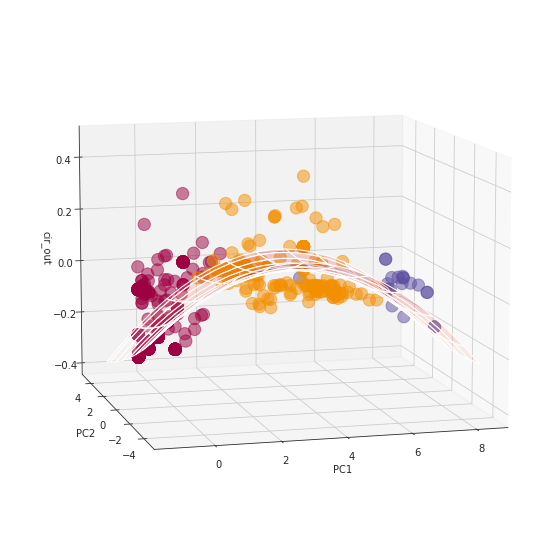

In [6]:
sns.set_style('ticks')
axis_name = ['PC1','PC2','cir_out'] # z-axis is the frustration out-influence of the circuit's state
surface_color = 'Reds'
draw_surface3D_customized(pd.merge(df, dat_act9, how='inner', left_index=True, right_index=True), axis_name, surface_color) 
